In [4]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
from meep_material import lorentzfit

In [18]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                       ):    
        # 1. 데이터 로드 및 전처리,
        data = np.genfromtxt(Material_data_csv, delimiter=",")
        wl = data[:, 0] * 1e6  # 파장 (µm),
        n_data = data[:, 1] + 1j * data[:, 2]
        eps_all = np.square(n_data) - eps_inf
    
        # 피팅 범위로 데이터 선택,
        mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
        wl_fit, eps_fit = wl[mask], eps_all[mask]
        freqs_fit = 1 / wl_fit
    
        # 2. Lorentzian 피팅 최적화,
        ps = np.zeros((iteration, 3 * num_lorentzians))
        errors = np.zeros(iteration)
        for m in range(iteration):
            p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
            ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
            print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
        best = np.argmin(errors)
        print(f"Optimal error: {errors[best]:.6f}")
    
        # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성,
        suscept = []
        for i in range(num_lorentzians):
            freq_param = ps[best][3*i + 1]
            gamma = ps[best][3*i + 2]
            if freq_param == 0:
                sigma = ps[best][3*i + 0]
                suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
            else:
                sigma = ps[best][3*i + 0] / freq_param**2
                suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))
    
        return eps_inf, suscept
    
sio2_data_path = "/home/m2ni/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/fdtd_data_SiO2_Palik.csv"
al_data_path   = "/home/m2ni/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/m2ni/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/fdtd_data_aNPD_PFA.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.000000
Iteration   1, error: 0.000000
Iteration   2, error: 0.000000
Iteration   3, error: 0.000000
Iteration   4, error: 0.000000
Iteration   5, error: 0.000000
Iteration   6, error: 0.000000
Iteration   7, error: 0.000000
Iteration   8, error: 0.000000
Iteration   9, error: 0.000000
Iteration  10, error: 0.000000
Iteration  11, error: 0.000000
Iteration  12, error: 0.000000
Iteration  13, error: 0.000000
Iteration  14, error: 0.000000
Iteration  15, error: 0.000000
Iteration  16, error: 0.000000
Iteration  17, error: 0.000000
Iteration  18, error: 0.000000
Iteration  19, error: 0.000000
Iteration  20, error: 0.000000
Iteration  21, error: 0.000000
Iteration  22, error: 0.000000
Iteration  23, error: 0.000000
Iteration  24, error: 0.000000
Iteration  25, error: 0.000000
Iteration  26, error: 0.000000
Iteration  27, error: 0.000000
Iteration  28, error: 0.000000
Iteration  29, error: 0.000000
Optimal error: 0.000000
Iteration   0, error: 64.226780
Iteration   1,

In [24]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000127077 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 100
time for set_epsilon = 0.057888 s
-----------
ldos0:, 1.4285714285714288, 0.7144502822053472
ldos0:, 1.4321548017200194, 0.7163367761240798
ldos0:, 1.43573817486861, 0.7182723184399172
ldos0:, 1.4393215480172004, 0.7201046747640735
ldos0:, 1.442904921165791, 0.7217945864538683
ldos0:, 1.4464882943143815, 0.7234556823990859
ldos0:, 1.4500716674629721, 0.7252303681313345
ldos0:, 1.4536550406115627, 0.7271371784203906
ldos0:, 1.457238413760153, 0.7290531525318762
ldos0:, 1.4608217869087436, 0.730847685591699
ldos0:, 1.4644051600573342, 0.7325222170039087
ldos0:, 1.4679885332059248, 0.7342064168813847
ldos0:, 1.4715719063545154, 0.7360174183425182
ldos0:, 1.4751552795031058, 0.7379348486839823
ldos0:, 1.4787386526516964, 0.739824925937766
ldos0:, 1.482322025800287, 0.7415853532299008
ldos0:, 1.4859053989488775, 0.7432541400044234


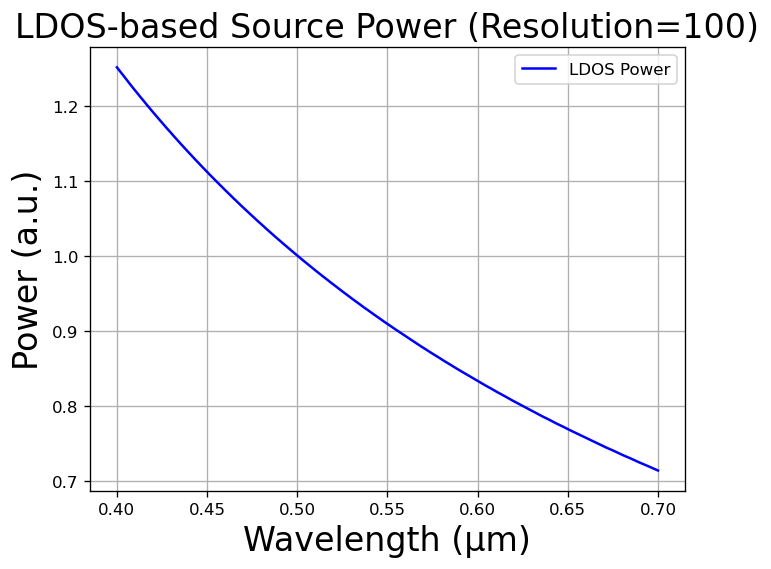

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import csv

# === 설정 ===
resolution = 100  # ★ 함수 인자였던 것을 변수로 설정
cell_size = mp.Vector3(3, 3, 0)
fcen = 1.75
df = 3.3
nfreq = 300

field_component = mp.Ex

lambda_min = 0.4
lambda_max = 0.7
fmin = 1 / lambda_max
fmax = 1 / lambda_min
fcen_dft = 0.5 * (fmin + fmax)
df_dft = fmax - fmin

# 소스 설정
source_center = mp.Vector3(0, 0, 0)
sources = [
    mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=field_component,
        center=source_center,
        size=mp.Vector3(0, 0)
    )
]

air = mp.Medium(index = 1)
alq3 = mp.Medium(index = 1.68)
SiO2 = mp.

# PML 설정
pml_layers = [mp.PML(0.3)]

# 시뮬레이션 객체 생성
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=
    default_material=mp.Medium(index=1.0),
    sources=sources,
    resolution=resolution
)

# === LDOS 객체 생성 ===
freqs = np.linspace(fcen_dft - df_dft/2, fcen_dft + df_dft/2, nfreq)
ldos_obj = mp.Ldos(freqs)

# === 시뮬레이션 실행 ===
sim.run(
    mp.dft_ldos(ldos=ldos_obj),
    until=50
)

# === 결과 얻기 ===
ldos_power = np.array(sim.ldos_data)  # (W) 단위 power
flux_freqs = np.array(mp.get_ldos_freqs(ldos_obj))  # (1/μm) 단위 주파수
wavelengths = 1 / flux_freqs  # (μm) 단위 파장

# === CSV 저장 ===
csv_filename = f"ldos_sourcepower_res{resolution}.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Wavelength (μm)", "LDOS Power (a.u.)"])
    for wl, power in zip(wavelengths, ldos_power):
        writer.writerow([wl, power])

print(f"CSV 파일 저장 완료: {csv_filename}")

# === 플롯 저장 ===
plt.figure(dpi=120)
plt.plot(wavelengths, ldos_power, label="LDOS Power", color='blue')
plt.xlabel("Wavelength (μm)", fontsize = 20)
plt.ylabel("Power (a.u.)", fontsize = 20)
plt.title(f"LDOS-based Source Power [] (Resolution={resolution})", fontsize = 20)
plt.grid(True)
plt.legend()


In [ ]:

plot_filename = f"ldos_sourcepower_res{resolution}.png"
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.close()

print(f"플롯 이미지 저장 완료: {plot_filename}")
